# **1. Import**

In [ ]:
!pip install -U snorkel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install luminol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.5/824.5 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.16.0-py3-none-any.whl size=487792 sha256=71676b966e28cc73ccc38d180426bee0ea3ffc21ea9bac342b18033a947992f0
  Stored in directory: /root/.cache/pip/wheels/99/10/cf/94af142fb7fe16e7327b17dc4d6d69ed041f8ec74b1fef10b2
Successfully built future
  Attempting uninstall: future
    Found existing installation: future 0.18.3
    Uninstalling future-0.18.3:
      Successfully uninstalled future-0.18.3


In [ ]:
!pip install rrcf

  Preparing metadata (setup.py) ... done
  Created wheel for rrcf: filename=rrcf-0.4.4-py3-none-any.whl size=10601 sha256=c8a082cbb34dbfe08d9cf3d7a46faea47ac6280d410fc2d85abd9889d831a46e
  Stored in directory: /root/.cache/pip/wheels/51/d4/43/6ac8270752946ee2223022ce0ed0d66c9455d000e1facb53a6
Successfully built rrcf


In [ ]:
!git clone https://github.com/xchuwenbo/realseries.git

Cloning into 'realseries'...
remote: Enumerating objects: 177, done.
remote: Total 177 (delta 0), reused 0 (delta 0), pack-reused 177
Receiving objects: 100% (177/177), 4.63 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from sklearn.metrics import average_precision_score

from snorkel.labeling.model import MajorityLabelVoter, LabelModel

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
import realseries
from realseries.realseries.models.iforest import IForest
from realseries.realseries.models.sr import SpectralResidual
#from realseries.realseries.models.stl import STL
from realseries.realseries.models.lumino import Lumino
from realseries.realseries.models.rcforest import RCForest
from sklearn.svm import OneClassSVM

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Học kì 6/Đồ án/DS200/Dataset/'
data = pd.read_csv(path+'Data_processed.csv')

# **4. Model**

## 4.1. **Hàm**

In [ ]:
def pro(data):
  data['Date'] = pd.to_datetime(data['Date'])
  #data = data.sort_values('Date')
  data = data.set_index('Date')
  return data

def load_data(path):
    train_data = pro(pd.read_csv(path + "train_data.csv"))
    test_data = pro(pd.read_csv(path + "test_data.csv"))
    train_labels = pd.read_csv(path + "train_labels.csv")
    test_labels = pd.read_csv(path + "test_labels.csv")
    return train_data, test_data, train_labels, test_labels

In [ ]:
def evaluate_model(model, X_test, y_test, labels):
    # Dự đoán nhãn của tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính toán các thông số đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # In ra các thông số đánh giá
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # In ra báo cáo phân lớp
    print(classification_report(y_test, y_pred, target_names=labels))

    # Tính toán precision, recall và f1-score cho từng lớp
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    # In ra precision, recall và f1-score của từng lớp
    print("\nPrecision, Recall, F1-score for each class:\n")
    for i in range(len(labels)):
        print(labels[i])
        print("Precision:", precision[i])
        print("Recall:", recall[i])
        print("F1-score:", f1[i])
        print()



    # Tạo ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
def evaluate_model_cnn(model, X_test, y_test,labels):
    # Dự đoán nhãn của tập kiểm tra
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Tính toán các thông số đánh giá
    accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
    report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    # In ra các thông số đánh giá
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)
    print("\nPrecision, Recall, F1-score:\n")
    precision = precision_score(np.argmax(y_test, axis=1), y_pred, average=None)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred, average=None)
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average=None)
    for i in range(len(labels)):
        print(labels[i])
        print("Precision:", precision[i])
        print("Recall:", recall[i])
        print("F1-score:", f1[i])
        print()

    # Tạo ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Load data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
X = data.drop('Label', axis=1)
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

path = '/content/drive/MyDrive/Học kì 6/Đồ án/DS200/Dataset/'
# Save
X_train.to_csv(path+"train_data.csv")
y_train.to_csv(path+"train_labels.csv")
X_test.to_csv(path+"test_data.csv")
y_test.to_csv(path+"test_labels.csv")
"""

path = '/content/drive/MyDrive/Học kì 6/DS200/Dataset/Split/'
X_train, X_test, y_train, y_test = load_data(path)

In [ ]:
len(y_train)

14400

In [ ]:
y_test.value_counts()

Anomaly
0          9468
1           132
dtype: int64

## 4.2. **Trước khi xử lý cân bằng**

### 4.2.1. *Xây dựng và fit model*

In [ ]:
# 1. SVM
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train,y_train)

# 2. XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

# 3. Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# 4. Gradient Boosting Machine
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_train)

# 5. K-nearest neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

### 4.2.2. *Đánh giá mô hình*

SVM:
Accuracy: 0.9876041666666666
Precision: 0.9877580317096067
Recall: 0.9876041666666666
F1-score: 0.9825563070603245
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      9468
     Anomaly       1.00      0.10      0.18       132

    accuracy                           0.99      9600
   macro avg       0.99      0.55      0.59      9600
weighted avg       0.99      0.99      0.98      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9875873578804631
Recall: 1.0
F1-score: 0.9937549199685123

Anomaly
Precision: 1.0
Recall: 0.09848484848484848
F1-score: 0.1793103448275862



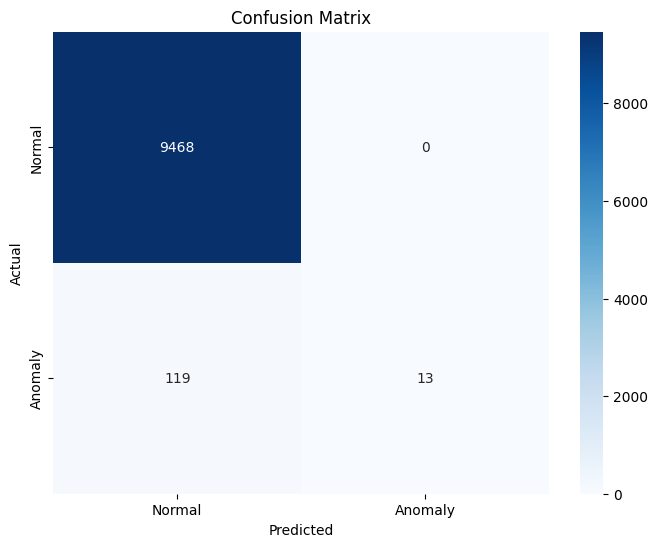

xgboost:
Accuracy: 0.9870833333333333
Precision: 0.9837734253382827
Recall: 0.9870833333333333
F1-score: 0.9844983347583385
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      9468
     Anomaly       0.57      0.24      0.34       132

    accuracy                           0.99      9600
   macro avg       0.78      0.62      0.67      9600
weighted avg       0.98      0.99      0.98      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9895222129086337
Recall: 0.9974651457541192
F1-score: 0.993477803492531

Anomaly
Precision: 0.5714285714285714
Recall: 0.24242424242424243
F1-score: 0.3404255319148936



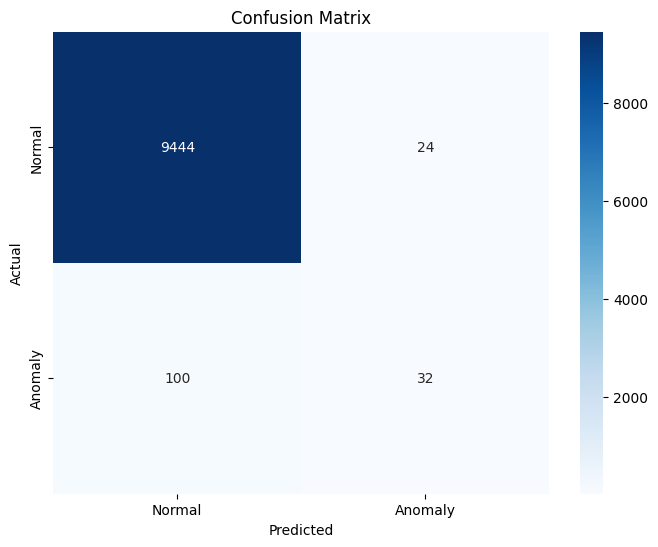

Random Forest:
Accuracy: 0.9880208333333333
Precision: 0.9852877201324748
Recall: 0.9880208333333333
F1-score: 0.9852033837049848
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      9468
     Anomaly       0.68      0.24      0.36       132

    accuracy                           0.99      9600
   macro avg       0.84      0.62      0.68      9600
weighted avg       0.99      0.99      0.99      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9895320841620433
Recall: 0.9984157160963245
F1-score: 0.9939540507859735

Anomaly
Precision: 0.6808510638297872
Recall: 0.24242424242424243
F1-score: 0.3575418994413408



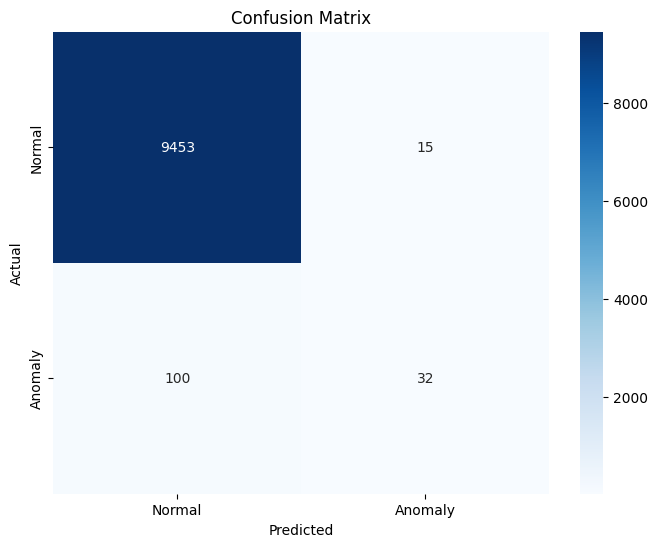

Gradient Boosting Machine:
Accuracy: 0.98875
Precision: 0.9870496978170168
Recall: 0.98875
F1-score: 0.9856674909585484
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      9468
     Anomaly       0.82      0.23      0.36       132

    accuracy                           0.99      9600
   macro avg       0.90      0.62      0.68      9600
weighted avg       0.99      0.99      0.99      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9894373562016314
Recall: 0.9992606675116181
F1-score: 0.9943247503941146

Anomaly
Precision: 0.8157894736842105
Recall: 0.23484848484848486
F1-score: 0.36470588235294116



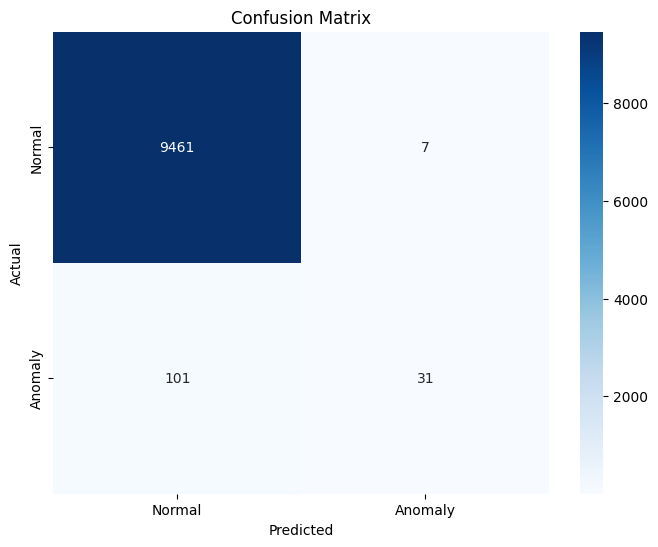

K-nearest neighbors (KNN):
Accuracy: 0.9869791666666666
Precision: 0.9842763337371921
Recall: 0.9869791666666666
F1-score: 0.981676793130593
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      9468
     Anomaly       0.77      0.08      0.14       132

    accuracy                           0.99      9600
   macro avg       0.88      0.54      0.57      9600
weighted avg       0.98      0.99      0.98      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9872744341295504
Recall: 0.9996831432192649
F1-score: 0.9934400419837313

Anomaly
Precision: 0.7692307692307693
Recall: 0.07575757575757576
F1-score: 0.13793103448275862



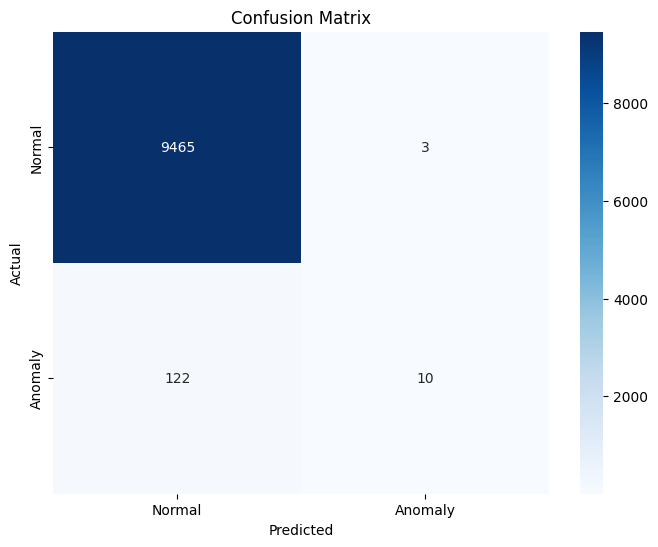

In [ ]:
labels =['Normal','Anomaly']

print("SVM:")
evaluate_model(svm_model, X_test, y_test, labels)

print("xgboost:")
evaluate_model(xgb_model, X_test, y_test, labels)

print("Random Forest:")
evaluate_model(rf_model, X_test, y_test, labels)

print("Gradient Boosting Machine:")
evaluate_model(gbm_model, X_test, y_test, labels)

print("K-nearest neighbors (KNN):")
evaluate_model(knn_model, X_test, y_test, labels)

### 4.2.3. *Lưu model*

In [ ]:
import joblib

In [ ]:
# save
path_model = '/content/drive/MyDrive/Học kì 6/DS200/Model/'

joblib.dump(svm_model, path_model + "svm_model.pkl")
xgb_model.save_model(path_model + "xgb_model.h5")
joblib.dump(rf_model, path_model + "rf_model.pkl")
joblib.dump(gbm_model, path_model + "gbm_model.pkl")
joblib.dump(knn_model, path_model + "knn_model.pkl")

['/content/drive/MyDrive/Học kì 6/DS200/Model/knn_model.pkl']

## 4.3. **Sau khi xử lý cân bằng**

In [ ]:
# In số lượng mẫu của từng lớp trước khi áp dụng SMOTE
print("Số lượng mẫu huấn luyện trước khi SMOTE:")
print(y_train.value_counts())

# Áp dụng SMOTE để điều chỉnh mẫu trên tập huấn luyện
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# In số lượng mẫu của từng lớp sau khi áp dụng SMOTE
print("Số lượng mẫu huấn luyện sau khi SMOTE:")
print(y_train_resampled.value_counts())

Số lượng mẫu huấn luyện trước khi SMOTE:
Anomaly
0          14202
1            198
dtype: int64
Số lượng mẫu huấn luyện sau khi SMOTE:
Anomaly
0          14202
1          14202
dtype: int64


### 4.3.1. *Xây dựng và fit model*

In [ ]:
# 1. SVM
svm_model_1 = SVC(kernel='rbf')
svm_model_1.fit(X_train_resampled,y_train_resampled)

# 2. XGBoost
xgb_model_1 = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model_1.fit(X_train_resampled, y_train_resampled)

# 3. Random Forest
rf_model_1 = RandomForestClassifier()
rf_model_1.fit(X_train_resampled, y_train_resampled)

# 4. Gradient Boosting Machine
gbm_model_1 = GradientBoostingClassifier()
gbm_model_1.fit(X_train_resampled, y_train_resampled)

# 5. K-nearest neighbors (KNN)
knn_model_1 = KNeighborsClassifier()
knn_model_1.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier()

### 4.3.2. *Đánh giá mô hình*

SVM:
Accuracy: 0.80125
Precision: 0.9821343245175848
Recall: 0.80125
F1-score: 0.8774633659379448
              precision    recall  f1-score   support

      Normal       1.00      0.80      0.89      9468
     Anomaly       0.05      0.72      0.09       132

    accuracy                           0.80      9600
   macro avg       0.52      0.76      0.49      9600
weighted avg       0.98      0.80      0.88      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9951532617238669
Recall: 0.8023869877482045
F1-score: 0.8884341012747047

Anomaly
Precision: 0.04832146490335707
Recall: 0.7196969696969697
F1-score: 0.0905624404194471



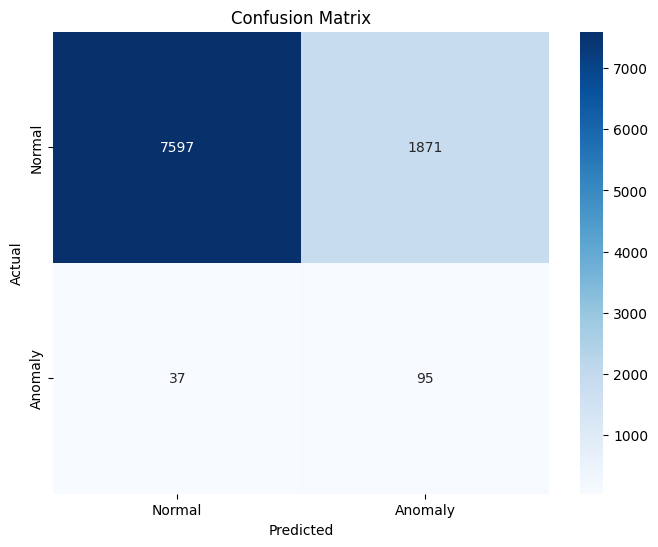

xgboost:
Accuracy: 0.9196875
Precision: 0.9832923574760666
Recall: 0.9196875
F1-score: 0.9472221113437088
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96      9468
     Anomaly       0.11      0.70      0.19       132

    accuracy                           0.92      9600
   macro avg       0.55      0.81      0.58      9600
weighted avg       0.98      0.92      0.95      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.995442634157457
Recall: 0.9227925644275454
F1-score: 0.9577418470813922

Anomaly
Precision: 0.1117861482381531
Recall: 0.696969696969697
F1-score: 0.19267015706806284



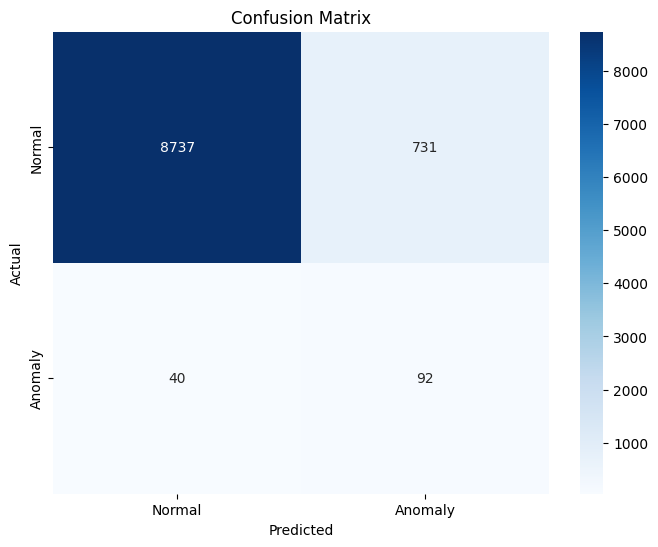

Random Forest:
Accuracy: 0.9166666666666666
Precision: 0.9843441166014931
Recall: 0.9166666666666666
F1-score: 0.9456655432952097
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96      9468
     Anomaly       0.12      0.77      0.20       132

    accuracy                           0.92      9600
   macro avg       0.56      0.84      0.58      9600
weighted avg       0.98      0.92      0.95      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9964490263459336
Recall: 0.9187790452049007
F1-score: 0.956039125178591

Anomaly
Precision: 0.11609195402298851
Recall: 0.7651515151515151
F1-score: 0.20159680638722555



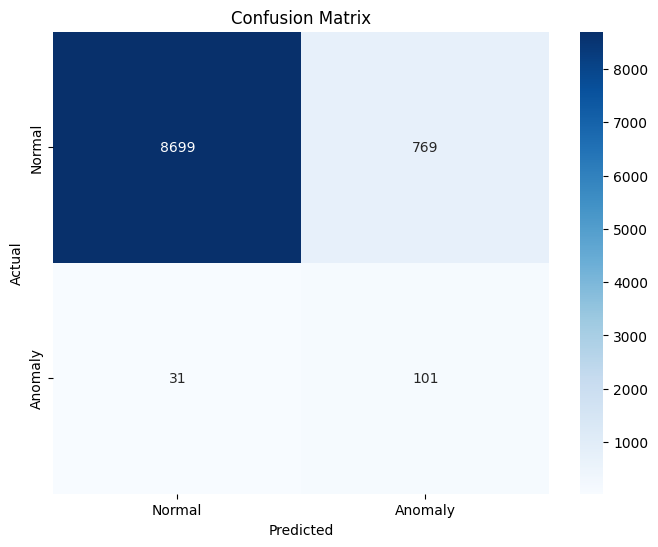

Gradient Boosting Machine:
Accuracy: 0.881875
Precision: 0.9856563384983055
Recall: 0.881875
F1-score: 0.9258731906301665
              precision    recall  f1-score   support

      Normal       1.00      0.88      0.94      9468
     Anomaly       0.09      0.88      0.17       132

    accuracy                           0.88      9600
   macro avg       0.55      0.88      0.55      9600
weighted avg       0.99      0.88      0.93      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9980874970117141
Recall: 0.8819180397127165
F1-score: 0.9364135920152518

Anomaly
Precision: 0.0940032414910859
Recall: 0.8787878787878788
F1-score: 0.1698389458272328



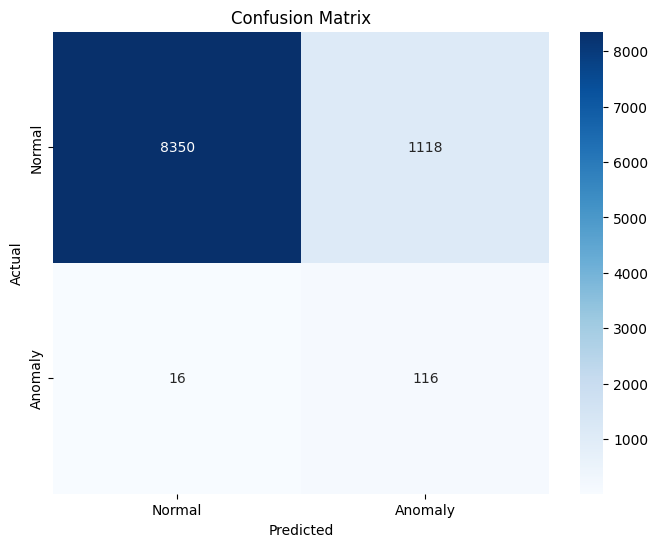

K-nearest neighbors (KNN):
Accuracy: 0.8146875
Precision: 0.9790935771126973
Recall: 0.8146875
F1-score: 0.8857247141630247
              precision    recall  f1-score   support

      Normal       0.99      0.82      0.90      9468
     Anomaly       0.04      0.54      0.07       132

    accuracy                           0.81      9600
   macro avg       0.52      0.68      0.49      9600
weighted avg       0.98      0.81      0.89      9600


Precision, Recall, F1-score for each class:

Normal
Precision: 0.9921905005761106
Recall: 0.8185466835656949
F1-score: 0.8970426529313038

Anomaly
Precision: 0.039686975964225824
Recall: 0.5378787878787878
F1-score: 0.07391983342009371



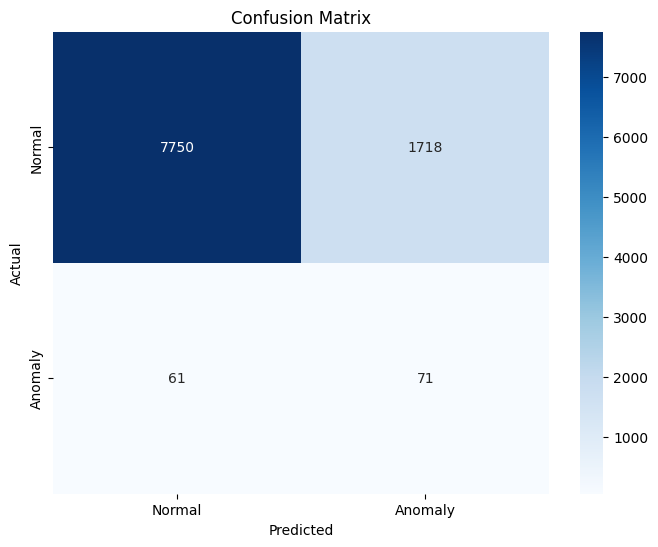

In [ ]:
labels =['Normal','Anomaly']

print("SVM:")
evaluate_model(svm_model_1, X_test, y_test, labels)

print("xgboost:")
evaluate_model(xgb_model_1, X_test, y_test, labels)

print("Random Forest:")
evaluate_model(rf_model_1, X_test, y_test, labels)

print("Gradient Boosting Machine:")
evaluate_model(gbm_model_1, X_test, y_test, labels)

print("K-nearest neighbors (KNN):")
evaluate_model(knn_model_1, X_test, y_test, labels)

### 4.3.3. *Lưu model*

In [ ]:
# save
path_model = '/content/drive/MyDrive/Học kì 6/DS200/Model/'

joblib.dump(svm_model_1, path_model + "svm_model_sampling.pkl")
xgb_model_1.save_model(path_model + "xgb_model_sampling.h5")
joblib.dump(rf_model_1, path_model + "rf_model_sampling.pkl")
joblib.dump(gbm_model_1, path_model + "gbm_model_sampling.pkl")
joblib.dump(knn_model_1, path_model + "knn_model_sampling.pkl")

['/content/drive/MyDrive/Học kì 6/DS200/Model/knn_model_sampling.pkl']